In [1]:
import dimod
import neal
import numpy as np
import pprint
import time
import os
import pickle
import dwave_token
import dwave.inspector

from dwave.system import DWaveSampler, DWaveCliqueSampler, LeapHybridCQMSampler
from dwave.system import AutoEmbeddingComposite, FixedEmbeddingComposite, CutOffComposite

# automatically generated embedding:
sampler = AutoEmbeddingComposite(DWaveSampler(token=dwave_token.value))
clique_sampler = DWaveCliqueSampler(token=dwave_token.value)
hybrid_sampler = LeapHybridCQMSampler(token=dwave_token.value)
simulated_sampler = neal.SimulatedAnnealingSampler()

In [9]:
n = 200
scaling = 10

# generate random upper triangle matrix
Q = scaling*np.triu(-1+2*np.random.rand(n,n))
for i in range(n): # do not allow small values
    for j in range(i,n):
        if abs(Q[i,j]) < 0.01:
            Q[i,j] = np.sign(-1+2*np.random.rand() * (0.01 + 0.99*np.random.rand()))
# print(Q)
# convert into binary quadratic model
bqm = dimod.BinaryQuadraticModel.from_qubo(Q)
chain_strength = scaling # set chain strength close to largest QUBO entry

In [3]:
Ising = dimod.utilities.qubo_to_ising({(i,j):Q[i,j] for i in range(n) for j in range(i,n)})
for i in range(n):
    if abs(Ising[0][i]) < 0.01:
        Ising[0][i] = np.sign(-1+2*np.random.rand() * (0.01 + 0.99*np.random.rand()))
    for j in range(i+1,n):
        if abs(Ising[1][i,j]) < 0.01:
            Ising[1][i,j] = np.sign(-1+2*np.random.rand() * (0.01 + 0.99*np.random.rand()))
bqm = dimod.BinaryQuadraticModel.from_ising(Ising[0],Ising[1]) # model creation

In [5]:
# run calculation
chain_strength = scaling # set chain strength close to largest QUBO entry
sampleset = sampler.sample(
    bqm,
    num_reads=100,
    chain_strength=chain_strength
)
print('minimum: ' + str(sampleset.lowest().first.energy))
print(str(n) + ' variables encoded in ' + str(len([node for nodes in sampleset.info['embedding_context']['embedding'].values() for node in nodes])) + ' physical qubits')

minimum: -1998.3383045847684
100 variables encoded in 1267 physical qubits


In [4]:
#comparison when running the same problem on the Clique Sampler:
sampleset2 = clique_sampler.sample(
    bqm,
    num_reads=1000,
    chain_strength=chain_strength
)
print('minimum: ' + str(sampleset2.lowest().first.energy))
print(str(n) + ' variables encoded in ' + str(len([node for nodes in sampleset2.info['embedding_context']['embedding'].values() for node in nodes])) + ' physical qubits')

minimum: -1655.0929967267894
100 variables encoded in 982 physical qubits


In [10]:
#comparison when running the same problem on the Hybrid Sampler:
cqm = dimod.ConstrainedQuadraticModel.from_bqm(bqm)
sampleset3 = hybrid_sampler.sample_cqm(
    cqm,
    time_limit = 5,
    )
print('minimum: ' + str(sampleset3.lowest().first.energy))

minimum: -5097.6261461635395


In [11]:
#comparison when running the same problem on simulated annealing:
sampleset4 = simulated_sampler.sample(
    bqm,
    num_reads=1000,
    chain_strength=chain_strength
)
print('minimum: ' + str(sampleset4.lowest().first.energy))

minimum: -5097.626146163578


In [35]:
# comparison when running with cutoff:
cutoff = 2.1
sampleset5 = CutOffComposite(sampler, cutoff).sample(
    bqm,
    num_reads=100,
    chain_strength=chain_strength
)
print('minimum: ' + str(sampleset5.lowest().first.energy))
#print(str(n) + ' variables encoded in ' + str(len([node for nodes in sampleset5.info['embedding_context']['embedding'].values() for node in nodes])) + ' physical qubits')

minimum: -4472.239493432756


In [27]:
np.diag(Q)

array([-1.35986959,  1.49402236, -1.87383377,  4.97455884, -2.91158476,
       -8.36576968,  5.16145745, -7.69797602, -6.17214498, -8.98350261,
       -6.74083093,  1.34696038, -9.5618722 , -8.30221462, -4.38269344,
       -9.55596604, -8.76931816, -6.41333142,  4.29365209, -1.61229485,
       -2.97888878, -2.33517716, -8.92780391, -4.76222707,  7.61217343,
       -8.5297313 ,  3.96686705,  9.42041092,  6.9884969 ,  3.19704075,
       -4.90323362, -2.17833186, -9.95593999, -8.6305805 , -8.57647533,
        5.83738046, -5.70754126, -0.37254439, -2.64543821,  6.47134439,
       -6.95310637, -4.73045034, -2.98902107,  6.49703702,  7.10978349,
       -5.89225226, -5.74770741, -7.75831573, -1.90711442, -2.28116819,
        6.17117915,  7.5293591 , -9.83379512, -5.40753776, -9.80979287,
        6.96145782, -2.74471688,  3.63354148, -9.50148471, -2.86487486,
        1.5543291 , -5.11621823, -7.73010301,  5.59994358, -7.69026335,
        7.29949685,  0.06703156, -8.29419687,  6.56304288, -1.10

In [11]:
# print(sampleset)
# pprint.pprint(sampleset.info)
dwave.inspector.show(sampleset)

Serving Inspector on http://127.0.0.1:18000/?problemId=342a3cc5-f4c5-4719-abc0-daab1b927011

'http://127.0.0.1:18000/?problemId=342a3cc5-f4c5-4719-abc0-daab1b927011'

In [12]:
dwave.inspector.show(sampleset5)

ValueError: invalid combination of arguments provided: if data capture not enabled, problem/response/solver have to be specified; also, make sure a structured problem is being inspected

In [ ]:
# save embedding:
file_name = str(n) + '_QUBO'
embedding_folder = 'Embeddings'
embedding_file_name = file_name + '_embedding.pkl'
with open(os.path.join(embedding_folder,embedding_file_name), 'wb') as f:
    pickle.dump(sampleset.to_serializable()['info']['embedding_context']['embedding'], f)

In [5]:
# fixed embedding:
embedding = sampleset.info['embedding_context']['embedding']
fixed_sampler = FixedEmbeddingComposite(child_sampler=DWaveSampler(token=dwave_token.value), embedding=embedding)

In [6]:
#compare embeddings on new QUBO:
P = scaling*np.triu(-1+2*np.random.rand(n,n))
bqm2 = dimod.BinaryQuadraticModel.from_qubo(P)
samplesetP = sampler.sample(
    bqm2,
    num_reads=1000,
    chain_strength=chain_strength
)
print('minimum: ' + str(samplesetP.lowest().first.energy))
if samplesetP.info['embedding_context']['embedding'] != embedding:
    print('Old embedding:')
    time_stamp = time.time()
    samplesetP2 = fixed_sampler.sample(
        bqm2,
        num_reads=1000,
        chain_strength=chain_strength
    )
    print('minimum: ' + str(samplesetP2.lowest().first.energy))
    print('Time for fixed embedding calculation:' + str(time.time()-time_stamp))

minimum: -1966.401191811369
Old embedding:
minimum: -1972.745190286486
Time for fixed embedding calculation:3.4141244888305664


In [7]:
dwave.inspector.show(samplesetP)

Serving Inspector on http://127.0.0.1:18000/?problemId=b04e2571-0219-42af-a5d6-6ae5582db524

'http://127.0.0.1:18000/?problemId=b04e2571-0219-42af-a5d6-6ae5582db524'

In [8]:
dwave.inspector.show(samplesetP2)

Serving Inspector on http://127.0.0.1:18000/?problemId=0c536058-335a-47ff-a55d-17ba0e66cdb3

'http://127.0.0.1:18000/?problemId=0c536058-335a-47ff-a55d-17ba0e66cdb3'

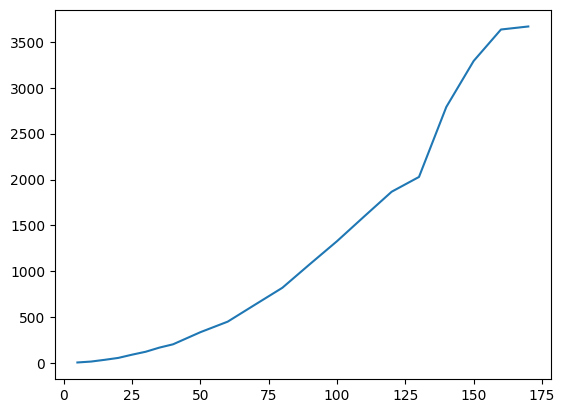

In [33]:
import matplotlib.pyplot as plt
# plot how many physical qubits where used per variables with random dense qubo (with all to all connection)
plt.plot(
    [5,10,15,20,25,30,35,40,50,60,70,80,90,100,110,120,130,140,150,160,170],
    [6,16,35,56,91,123,168,204,336,451,636,820,1076,1328,1599,1867,2028,2791,3292,3635,3668]
)
plt.show()